In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
!cp -r '/content/gdrive/My Drive/modeling' .

In [5]:
!pip install catboost optuna shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 
     |████████████████████████████████| 348 kB 64.1 MB/s 
     |████████████████████████████████| 81 kB 9.1 MB/s 
     |████████████████████████████████| 209 kB 50.7 MB/s 
     |████████████████████████████████| 78 kB 5.7 MB/s 
     |████████████████████████████████| 112 kB 32.0 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 147 kB 54.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=538998d0c878246359a5a552ba6bf9fb6bd686bf7b7c1c3329f937897be3410f
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [1]:
import pandas as pd
import gc
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier
import optuna

from tqdm.notebook import tqdm

np.warnings.filterwarnings('ignore')

In [2]:
CURRENT_DIR = './'  # имя текущей директории для каггл

PATH_TO_TRAIN = CURRENT_DIR + 'modeling/lab1/data'
# PATH_TO_TEST = CURRENT_DIR + 'input/alfabattle2-sandbox/alfabattle2_sand_alfabattle2_test_transactions_contest/test_transactions_contest'

PATH_TO_TRAIN_TARGET = CURRENT_DIR + 'modeling/lab2/alfabattle2_sand_alfabattle2_train_target.csv'
# PATH_TO_TEST_TARGET = CURRENT_DIR + 'input/alfabattle2-sandbox/alfabattle2_sand_alfabattle2_test_target_contest.csv'

PATH_TO_WORKDIR = CURRENT_DIR + 'working/'

In [3]:
CAT_COLUMNS = [
    'currency',
    'operation_kind',
    'card_type',
    'operation_type',
    'operation_type_group',
    'ecommerce_flag',
    'payment_system',
    'income_flag',
    'mcc',
    'country',
    'city',
    'mcc_category',
]

# Работа с данными

## Предобработка

In [4]:
def read_parquet_dataset_from_local(path_to_dataset: str, 
                                    start_from: int = 0,
                                    num_parts_to_read: int = 2, 
                                    columns=None, 
                                    verbose=False,
                                    info_num_parts=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразует их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    list_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset) 
                              if filename.startswith('part')])
    if info_num_parts:
        print(f'Кол-во партиций в папке: {len(list_paths)}')
    start_from = max(0, start_from)
    list_path_to_partitions = list_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for path_to_partition in list_path_to_partitions:
            print(path_to_partition)
    for path_to_parquet in tqdm(list_path_to_partitions,
                                desc="Читаем файлы:"):
        temp_parquet = pd.read_parquet(path_to_parquet,columns=columns)
        res.append(temp_parquet)
        del temp_parquet
        gc.collect()
    return pd.concat(res).reset_index(drop=True)

def __amnt_pivot_table_by_column_as_frame(frame, column, agg_funcs=None) -> pd.DataFrame:
    """
    Строит pivot table для между колонкой `amnt`  и column на основе переданных aggregations_on
    :param frame: pd.DataFrame транзакций
    :param column: название колонки, на основе `amnt`  и column будет построен pivot_table
    :param agg_funcs: список из функций, которые нужно применить, по умолчанию ['mean', 'count']
    :return: pd.DataFrame
    """
    if agg_funcs is None:
        agg_funcs = ['mean', 'count']
    aggs = pd.pivot_table(frame, values='amnt',
                          index=['app_id'], columns=[column],
                          aggfunc={'amnt': agg_funcs},
                          fill_value=0.0)
    aggs.columns = [f'{col[0]}_{column}_{col[1]}' for col in aggs.columns.values]
    return aggs

def extract_basic_aggregations(transactions_frame: pd.DataFrame, 
                               cat_columns=None, 
                               agg_funcs=None) -> pd.DataFrame:
    """
    :param transactions_frame: pd.DataFrame с транзакциями
    :param cat_columns: список категориальных переменных, для которых будут построены агрегаты по `amnt`
    :param agg_funcs: список функций, который нужно применить для подсчета агрегатов, 
    :по умолчанию ['sum', 'mean', 'count']
    :return: pd.DataFrame с извлеченными признаками
    """
    if not cat_columns:
        cat_columns = CAT_COLUMNS

    pivot_tables = []
    for col in cat_columns:
        pivot_tables.append(__amnt_pivot_table_by_column_as_frame(transactions_frame, column=col,
                                                                  agg_funcs=agg_funcs))
    pivot_tables = pd.concat(pivot_tables, axis=1)

    aggs = {
        # посчитаем статистики для транзакций
        'amnt': ['mean', 'median', 'sum', 'std'],
        # посчитаем разумные агрегаты для разницы в часах между транзакциями
        'hour_diff': ['max', 'mean', 'median', 'var', 'std'],
        # добавим самую раннюю/позднюю и среднюю дату транзакции до подачи заявки на кредит
        'days_before': ['min', 'max', 'median']}

    numeric_stats = transactions_frame.groupby(['app_id']).agg(aggs)

    # дадим разумные имена новым колонкам; может не работать в python 3.5, так как порядок ключей в словаре не
    # гарантирован
    numeric_stats.columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

    return pd.concat([pivot_tables, numeric_stats], axis=1).reset_index()

def prepare_transactions_dataset(path_to_dataset: str, 
                                 num_parts_to_preprocess_at_once: int = 1, 
                                 num_parts_total: int=50, 
                                 save_to_path=None, 
                                 verbose: bool=False):
    """
    :возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи.
    :path_to_dataset: str - путь до датасета с партициями
    :num_parts_to_preprocess_at_once: int - количество партиций, которые будут одновременно держаться в памяти и обрабатываться
    :num_parts_total: int - общее количество партиций, которые нужно обработать
    :save_to_path: str - путь до папки, в которой будет сохранен каждый обработанный блок в .parquet формате. Если None, то не будет сохранен 
    :verbose: bool - логирует каждый обрабатываемый кусок данных
    """
    preprocessed_frames = []
    block = 0
    for step in tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once), 
                                   desc="Общий прогресс препроцессинга:"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, 
                                                             step, 
                                                             num_parts_to_preprocess_at_once, 
                                                             verbose=verbose)
        features = extract_basic_aggregations(transactions_frame, 
                                              cat_columns=['mcc_category', 
                                                           'day_of_week', 
                                                           'operation_type'])
        if save_to_path:
            block_as_str = str(block)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            features.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))
            
        preprocessed_frames.append(features)
    return pd.concat(preprocessed_frames)

def reduce_mem_usage_df(d_df: pd.DataFrame):
    """
    :перебирает все столбцы датафрейма и изменяет тип данных для уменьшения использования памяти.
    """
    start_mem = d_df.memory_usage().sum() / 1024**2
    print('Размер памяти исходного датафрейма {:.2f} MB'.format(start_mem))
    
    d_log = []
    for col in d_df.columns:
        col_type = d_df[col].dtype

        if col_type != object:
            c_min = d_df[col].min()
            c_max = d_df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    d_df[col] = d_df[col].astype(np.int8)
                    d_log.append(f'{col} :from int64 to int8')
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    d_df[col] = d_df[col].astype(np.int16)
                    d_log.append(f'{col} :from int64 to int16')

    end_mem = d_df.memory_usage().sum() / 1024**2
    print('Размер памяти после оптимизации: {:.2f} MB'.format(end_mem))
    print('Уменьшено на {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    print('Список внесенных изменений вы можете посмотреть в логе')
    
    return d_df, d_log

In [5]:
train_data = prepare_transactions_dataset(PATH_TO_TRAIN,
                                          num_parts_to_preprocess_at_once=2, 
                                          num_parts_total=50)

Общий прогресс препроцессинга::   0%|          | 0/25 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
train_data, log_reduce_mem_train = reduce_mem_usage_df(train_data)

Размер памяти исходного датафрейма 933.87 MB
Размер памяти после оптимизации: 614.00 MB
Уменьшено на 34.3%
Список внесенных изменений вы можете посмотреть в логе


In [7]:
train_data = train_data.dropna(axis=1).reset_index(drop=True)

## Выделение трейн, валид и тест подвыборок

In [8]:
train_target = pd.read_csv(PATH_TO_TRAIN_TARGET)

train_val_features, test_features, train_val_target, test_target = train_test_split(train_data, train_target.flag, test_size=0.25, random_state=0)
train_features, val_features, train_target, val_target = train_test_split(train_val_features, train_val_target, test_size=0.33, random_state=0)

# Обучение

In [9]:
clf = CatBoostClassifier(random_state=0)

clf.fit(train_features, train_target, eval_set=(val_features, val_target), verbose=50)

Learning rate set to 0.145927
0:	learn: 0.4808088	test: 0.4807308	best: 0.4807308 (0)	total: 320ms	remaining: 5m 20s
50:	learn: 0.1132950	test: 0.1138683	best: 0.1138683 (50)	total: 15.6s	remaining: 4m 49s
100:	learn: 0.1112837	test: 0.1130478	best: 0.1130478 (100)	total: 29.8s	remaining: 4m 24s
150:	learn: 0.1097689	test: 0.1125912	best: 0.1125912 (150)	total: 43.1s	remaining: 4m 2s
200:	learn: 0.1085127	test: 0.1123765	best: 0.1123765 (200)	total: 56.3s	remaining: 3m 43s
250:	learn: 0.1075261	test: 0.1121787	best: 0.1121778 (249)	total: 1m 8s	remaining: 3m 25s
300:	learn: 0.1064470	test: 0.1120643	best: 0.1120529 (298)	total: 1m 22s	remaining: 3m 10s
350:	learn: 0.1056215	test: 0.1119693	best: 0.1119693 (350)	total: 1m 34s	remaining: 2m 55s
400:	learn: 0.1047818	test: 0.1119623	best: 0.1119514 (374)	total: 1m 47s	remaining: 2m 40s
450:	learn: 0.1039365	test: 0.1119159	best: 0.1119112 (447)	total: 2m	remaining: 2m 27s
500:	learn: 0.1032537	test: 0.1118902	best: 0.1118871 (493)	total: 

# Тестирование

Все 3 метрики f1, ROC AUC и коэффициент корреляции Мэтьюза могут учитывать несбалансированность классов.

In [10]:
from sklearn.metrics import f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix

In [26]:
probs = clf.predict_proba(test_features)[:, 1]
preds = clf.predict(test_features)

print('F1 score:', f1_score(test_target, preds))
print('ROC AUC score:', roc_auc_score(test_target, probs))
print('Matthews corrcoef:', matthews_corrcoef(test_target, preds))

F1 score: 0.010792984560035974
ROC AUC score: 0.765393440029112
Matthews corrcoef: 0.05006424260812468


In [28]:
confusion_matrix(test_target, preds)

array([[234318,     36],
       [  6563,     36]])

Модель дает много ложных срабатываний, предсказывая дефолт, когда дефолта нет. При этом ROC AUC достаточно высокий, возможно что F1 и коэффициент Мэттьюза не очень подходящие метрики.

Также я попробовал подобрать порог для предсказаний, что немного увеличило метрики.

In [25]:
probs = clf.predict_proba(test_features)[:, 1]
preds = probs > 0.1

print('F1 score:', f1_score(test_target, preds))
print('ROC AUC score:', roc_auc_score(test_target, probs))
print('Matthews corrcoef:', matthews_corrcoef(test_target, preds))

F1 score: 0.18214607754733997
ROC AUC score: 0.765393440029112
Matthews corrcoef: 0.15744975081915563


# Интерпретация

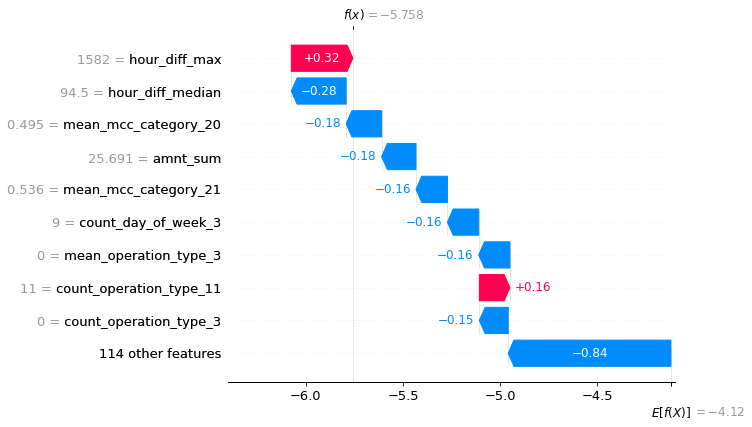

In [13]:
import shap

explainer = shap.Explainer(clf)
shap_values = explainer(train_features)

shap.plots.waterfall(shap_values[0])

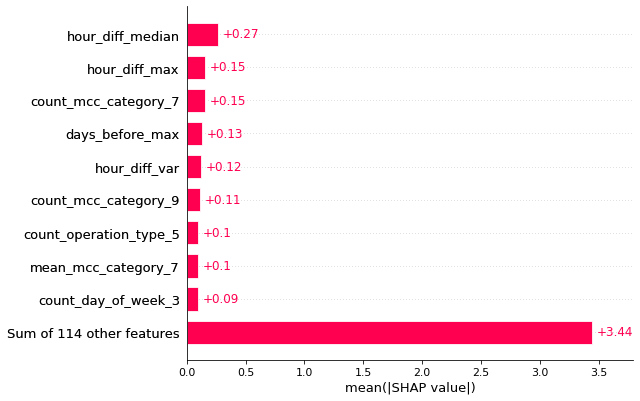

In [14]:
shap.plots.bar(shap_values)

Здесь не показаны все фичи, так как их слишком много, также нет сильно выделяющихся фич, от которых зависит результат модели. По тем, что есть на последнем графике, можно сказать, что чем выше hour_diff_median и hour_diff_max, тем выше шанс дефолта, то есть чем меньше транзакций совершает клиент, чем выше его шанс уйти в дефолт, тоже самое с фичей days_before_max и hour_diff_var.

Насчёт фичей, завязанных на mcc_category, нельзя что-либо однозначно сказать, так как неизвестно что это за категории (данные зашифрованы).